In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import Ridge
from sklearn.metrics import plot_roc_curve
from sklearn.linear_model import LogisticRegression

In [27]:
train_raw = pd.read_csv('train_pr.csv')
test = pd.read_csv('test_pr.csv')

In [28]:
split_date = '2014-03-01'
# разбиваем данные на обучающий и отложенный набор данных (train и out of time)
train = train_raw[train_raw['timestamp'] < split_date]
oot = train_raw[train_raw['timestamp'] >= split_date]

# создаем колонку по которой будем делать стратификацию данных
stratify = train['timestamp'].str[:-3] + '_' + train['__churn'].map(str)

# разбиваем датасет на обучающий и отложенный (train и out of sample) в соотношении 70% (train) на 30% (out of time) использую стратифицированную колонку
train, oos = train_test_split(train, test_size=0.3, random_state=47, stratify=stratify)

train.shape, oos.shape, oot.shape

((10906, 50), (4675, 50), (4902, 50))

In [29]:
remove_features = train.columns[train.columns.str.startswith('__')].tolist()
remove_features
continuous_features = list(set(train.dtypes[train.dtypes != 'object'].index.tolist()) 
                           - set(remove_features))
continuous_features

['public_transport_station_min_walk',
 'product_type',
 'oil_chemistry_raion',
 'mkad_km',
 'sport_count_2000',
 'credit_limit',
 'thermal_power_plant_raion',
 'avg_open_to_buy',
 'big_market_raion',
 'contacts_count_12_mon',
 'total_trans_ct',
 'detention_facility_raion',
 'customer_age',
 'railroad_1line',
 'culture_objects_top_25',
 'total_amt_chng_q4_q1',
 'dependent_count',
 'card_category',
 'income_category',
 'marital_status',
 'office_sqm_5000',
 'railroad_station_walk_km',
 'leisure_count_5000',
 'total_relationship_count',
 'nuclear_reactor_raion',
 'full_sq',
 'total_revolving_bal',
 'cafe_count_1000_price_1000',
 'gender',
 'months_inactive_12_mon',
 'trc_count_2000',
 'months_on_book',
 'market_count_1500',
 'incineration_raion',
 'total_ct_chng_q4_q1',
 'leisure_count_3000',
 'school_education_centers_top_20_raion',
 'water_1line',
 'avg_utilization_ratio',
 'ecology',
 'metro_km_walk',
 'floor',
 'railroad_terminal_raion',
 'education_level',
 'detention_facility_km',
 

In [30]:
X_train = train[continuous_features].fillna(0.).copy(True)
X_test = test[continuous_features].fillna(0.).copy(True)
X_oos = oos[continuous_features].fillna(0.).copy(True)
X_oot = oot[continuous_features].fillna(0.).copy(True)

X_y_datasets = [
    ('train', X_train, train),
    ('oos', X_oos, oos),
    ('oot', X_oot, oot)]

In [31]:
name, X_, y_ = X_y_datasets[0]

# создаем модель
reg_model = LinearRegression()
# обучаем модель
reg_model.fit(X_, y_['__price_doc'])

train_columns = X_.columns.tolist()

for name, X_, y_ in X_y_datasets:
    # получаем предсказания модели
    value = reg_model.predict(X_)
    # зануляем значения прогноза в случае если они ниже 0
    value[value < 0] = 0
    y_['__price_predict_linreg'] = value
    

C:\Users\1\AppData\Local\Temp\ipykernel_8948\913328655.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_['__price_predict_linreg'] = value


In [39]:
for name, X_, y_ in X_y_datasets:
    # получаем оценку качества модели
    value = mean_squared_log_error(y_true=y_['__price_doc'], y_pred=y_['__price_predict_linreg'])
    print(f'{name:10s}: {value:.4f}')

train     : 0.1705
oos       : 0.1638
oot       : 0.1716


In [40]:
name, X_, y_ = X_y_datasets[0]
for alpha in [0., 1., 10, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8]:

    print(f'\nalpha {alpha}')
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_, y_['__price_doc'])

    train_columns = X_.columns.tolist()

    for name, X_, y_ in X_y_datasets:
        value = ridge_model.predict(X_)
        value[value < 0] = 0
        y_['__price_predict_ridge'] = value
    
    for name, X_, y_ in X_y_datasets:
        value = mean_squared_log_error(y_true=y_['__price_doc'], y_pred=y_['__price_predict_ridge'])
        print(f'{name:10s}: {value:.4f}')
        


alpha 0.0
train     : 0.1705
oos       : 0.1638
oot       : 0.1716

alpha 1.0
train     : 0.1930
oos       : 0.1845
oot       : 0.1801

alpha 10
train     : 0.1917
oos       : 0.1830
oot       : 0.1785

alpha 100.0
train     : 0.1864
oos       : 0.1775
oot       : 0.1717

alpha 1000.0
train     : 0.1948
oos       : 0.1857
oot       : 0.1699

alpha 10000.0
train     : 0.2452
oos       : 0.2372
oot       : 0.2170

alpha 100000.0
train     : 0.2750
oos       : 0.2676
oot       : 0.2469

alpha 1000000.0
train     : 0.2813
oos       : 0.2739
oot       : 0.2531

alpha 10000000.0
train     : 0.2820
oos       : 0.2747
oot       : 0.2539

alpha 100000000.0
train     : 0.2820
oos       : 0.2747
oot       : 0.2539


C:\Users\1\AppData\Local\Temp\ipykernel_8948\1526424972.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_['__price_predict_ridge'] = value
C:\Users\1\AppData\Local\Temp\ipykernel_8948\1526424972.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_['__price_predict_ridge'] = value
C:\Users\1\AppData\Local\Temp\ipykernel_8948\1526424972.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [41]:
#попробуем разбивку сетки от 0 до 1: может это даст лучший результат

name, X_, y_ = X_y_datasets[0]
for alpha in [0., 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:

    print(f'\nalpha {alpha}')
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_, y_['__price_doc'])

    train_columns = X_.columns.tolist()

    for name, X_, y_ in X_y_datasets:
        value = ridge_model.predict(X_)
        value[value < 0] = 0
        y_['__price_predict_ridge'] = value
    for name, X_, y_ in X_y_datasets:
        value = mean_squared_log_error(y_true=y_['__price_doc'], y_pred=y_['__price_predict_ridge'])
        print(f'{name:10s}: {value:.4f}')


alpha 0.0
train     : 0.1705
oos       : 0.1638
oot       : 0.1716

alpha 0.1
train     : 0.1932
oos       : 0.1849
oot       : 0.1804

alpha 0.2
train     : 0.1932
oos       : 0.1848
oot       : 0.1804

alpha 0.3
train     : 0.1931
oos       : 0.1848
oot       : 0.1804

alpha 0.4
train     : 0.1931
oos       : 0.1847
oot       : 0.1804

alpha 0.5
train     : 0.1931
oos       : 0.1847
oot       : 0.1803

alpha 0.6
train     : 0.1931
oos       : 0.1846
oot       : 0.1803

alpha 0.7
train     : 0.1930
oos       : 0.1846
oot       : 0.1803

alpha 0.8
train     : 0.1930
oos       : 0.1846
oot       : 0.1802

alpha 0.9
train     : 0.1930
oos       : 0.1845
oot       : 0.1802

alpha 1
train     : 0.1930
oos       : 0.1845
oot       : 0.1801


C:\Users\1\AppData\Local\Temp\ipykernel_8948\827175997.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_['__price_predict_ridge'] = value
C:\Users\1\AppData\Local\Temp\ipykernel_8948\827175997.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_['__price_predict_ridge'] = value
C:\Users\1\AppData\Local\Temp\ipykernel_8948\827175997.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [42]:
#фактически лучшая модель - без регуляризации с RMSE 0.1705 0.1638 0.1716

D:\conda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


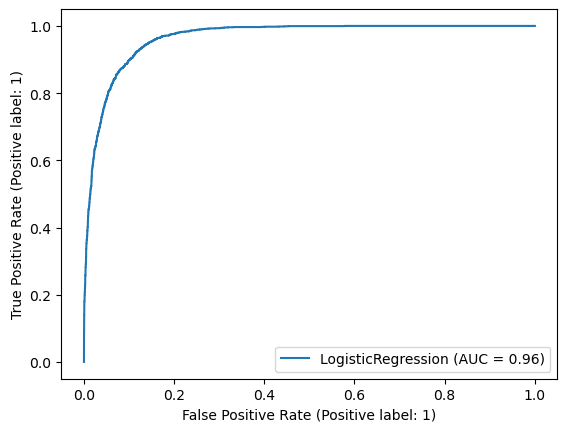

In [44]:
name, X_, y_ = X_y_datasets[0]
log_model = LogisticRegression(max_iter=1000,C=1,solver="liblinear")
log_model.fit(X_, y_['__churn'])
plot_roc_curve(log_model, X_, y_['__churn'])

In [49]:
name, X_, y_ = X_y_datasets[0]
for alpha in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:

    print(f'\nalpha {alpha}')
    log_model = LogisticRegression(max_iter=1000,C=alpha,penalty="l2",solver="liblinear")
    log_model.fit(X_, y_['__churn'])

    train_columns = X_.columns.tolist()

    for name, X_, y_ in X_y_datasets:
        value = []
        for j in range(len(log_model.predict_proba(X_))):
            value.append(log_model.predict_proba(X_)[j][1])
        #value[value < 0] = 0
        y_['__churn_predict_log'] = value
    
    for name, X_, y_ in X_y_datasets:
        value = roc_auc_score(y_['__churn'], y_['__churn_predict_log'])
        print(f'{name:10s}: {value:.4f}')


alpha 0.1


C:\Users\1\AppData\Local\Temp\ipykernel_8948\14289047.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_['__churn_predict_log'] = value


train     : 0.9640
oos       : 0.9668
oot       : 0.9624

alpha 0.2


C:\Users\1\AppData\Local\Temp\ipykernel_8948\14289047.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_['__churn_predict_log'] = value


train     : 0.9627
oos       : 0.9661
oot       : 0.9652

alpha 0.3


C:\Users\1\AppData\Local\Temp\ipykernel_8948\14289047.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_['__churn_predict_log'] = value


train     : 0.9629
oos       : 0.9663
oot       : 0.9657

alpha 0.4


C:\Users\1\AppData\Local\Temp\ipykernel_8948\14289047.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_['__churn_predict_log'] = value


train     : 0.9629
oos       : 0.9663
oot       : 0.9659

alpha 0.5


C:\Users\1\AppData\Local\Temp\ipykernel_8948\14289047.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_['__churn_predict_log'] = value


train     : 0.9629
oos       : 0.9663
oot       : 0.9660

alpha 0.6


C:\Users\1\AppData\Local\Temp\ipykernel_8948\14289047.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_['__churn_predict_log'] = value


train     : 0.9629
oos       : 0.9664
oot       : 0.9661

alpha 0.7


C:\Users\1\AppData\Local\Temp\ipykernel_8948\14289047.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_['__churn_predict_log'] = value


train     : 0.9629
oos       : 0.9663
oot       : 0.9661

alpha 0.8


C:\Users\1\AppData\Local\Temp\ipykernel_8948\14289047.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_['__churn_predict_log'] = value


train     : 0.9629
oos       : 0.9663
oot       : 0.9662

alpha 0.9


C:\Users\1\AppData\Local\Temp\ipykernel_8948\14289047.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_['__churn_predict_log'] = value


train     : 0.9629
oos       : 0.9663
oot       : 0.9662

alpha 1
train     : 0.9629
oos       : 0.9663
oot       : 0.9662


C:\Users\1\AppData\Local\Temp\ipykernel_8948\14289047.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_['__churn_predict_log'] = value


In [ ]:
#можно взять модели с силой регуляризации от 0.7 до 1 при этом auc составляет 0.9663 и 0.9662 